In [1]:
%matplotlib notebook
%load_ext autoreload

In [36]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
print(tf.VERSION)
print(tf.keras.__version__)

1.10.0
2.1.6-tf


In [3]:
import os
from collections import defaultdict
from sklearn import datasets, svm, metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [39]:
# Load data
digits = tf.keras.datasets.mnist

# Split data into train, test and validation set.
(X_train, y_train),(X_test, y_test) = digits.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

X_train, X_test,X_valid = X_train / 255.0, X_test / 255.0, X_valid / 255.0


In [99]:
X_train[0].shape

(28, 28)

In [5]:
image_shape = X_train[0].shape
image_size_flatten = X_train[0].reshape(-1).shape[0]
print("image shape = ",image_shape)
print("flatten image size = ",image_size_flatten)
print("image width/height = ",image_shape[0])

image shape =  (28, 28)
flatten image size =  784
image width/height =  28


<IPython.core.display.Javascript object>


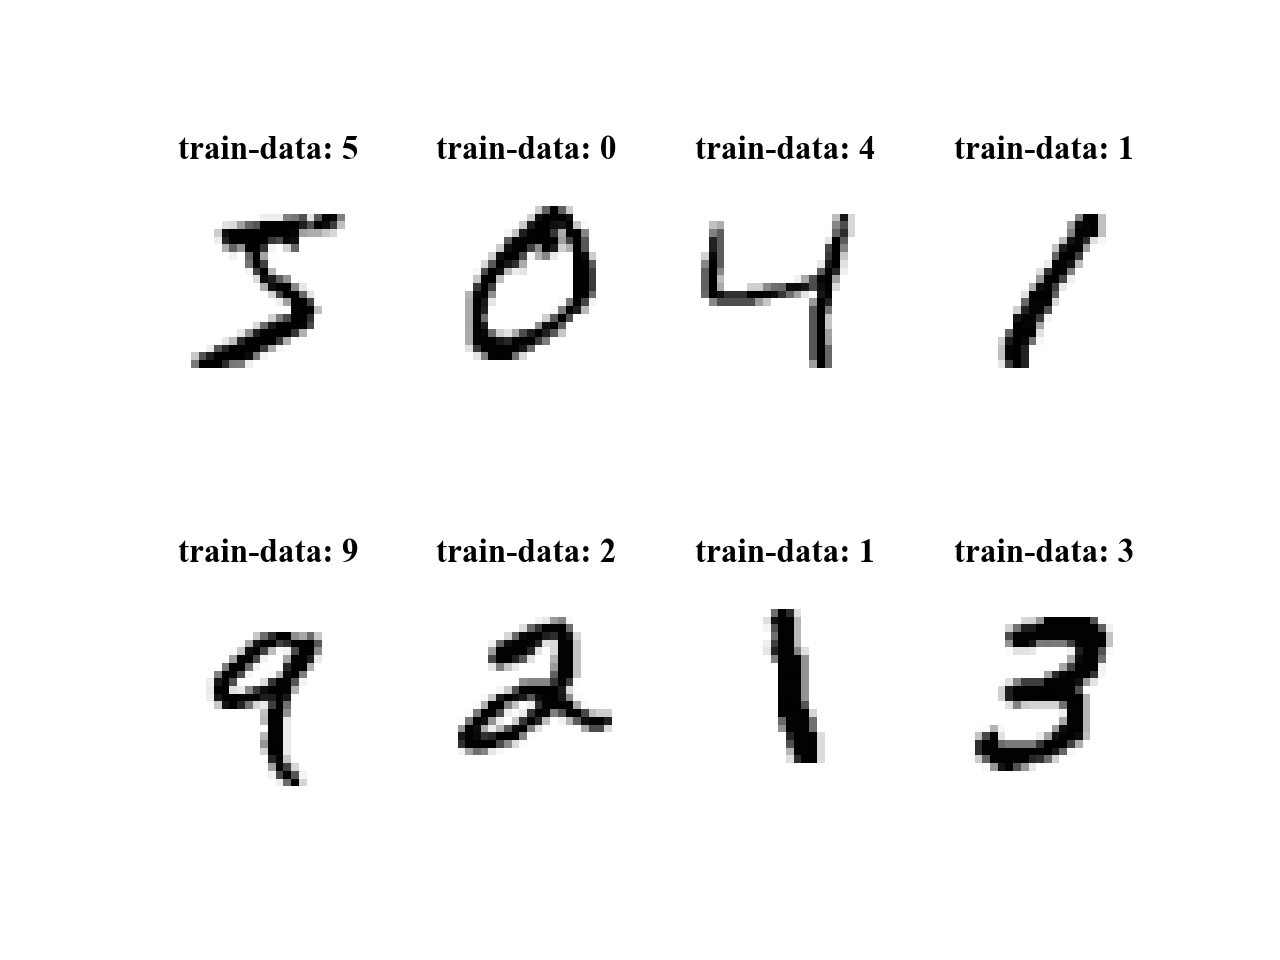

In [6]:
images_and_labels = list(zip(X_train[:8], y_train[:8]))
for index, (image, label) in enumerate(images_and_labels[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('train-data: {}'.format(label),size=12)

## Build CNN via Keras API


http://cs231n.github.io/convolutional-networks/

Summary. To summarize, the Conv Layer:

* Accepts a volume of size W1×H1×D1

* Requires four hyperparameters:
    * Number of filters K,
    * their spatial extent F,
    * the stride S,
    * the amount of zero padding P.
    
* Produces a volume of size W2×H2×D2 where:
    * W2=(W1−F+2P)/S+1
    * H2=(H1−F+2P)/S+1 (i.e. width and height are computed equally by symmetry)
    * D2=K
    
* With parameter sharing, it introduces F⋅F⋅D1 weights per filter, for a total of (F⋅F⋅D1)⋅K weights and K biases.
In the output volume, the d-th depth slice (of size W2×H2) is the result of performing a valid convolution of the d-th filter over the input volume with a stride of S, and then offset by d-th bias.


In [48]:
firstmodel=models.Sequential()

# # Reshape image from 1D-28x28 array to 2D-(28x28x1) array for CNN network
# firstmodel.add(layers.Reshape((image_shape[0],image_shape[1],1),
#                               input_shape=(image_size_flatten,),name='init_reshape'))

# First CNN layer with relu activation function. 
# Input dimensions
# w1 = h1 = 28 , D1 = 1 , k = 16 , S =1, P=1, F = 5
# weights = 5 x 5 matrix x D1 x filters
# bias = single values x filters
# w2 = h2 = ( w1 - F + 2P)/S + 1 = (28 - 5+2)/1+1 = 26
firstmodel.add(layers.Conv2D(kernel_size=5, strides=1, 
                        filters =16,padding='same',
                        activation='relu', 
                        input_shape=(image_shape[0],image_shape[1],1),
                        name='layer_conv1',
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros'))
firstmodel.add(layers.MaxPooling2D(pool_size=2, strides=2, name='P1'))

# Second convolutional layer with ReLU-activation and max-pooling.
firstmodel.add(layers.Conv2D(kernel_size=5, strides=1, 
                             filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
firstmodel.add(layers.MaxPooling2D(pool_size=2, strides=2, name='P2'))
firstmodel.add(layers.Dropout(0.25,name='D1'))

# 
firstmodel.add(layers.Flatten())

firstmodel.add(layers.Dense(256, activation='relu'))
firstmodel.add(layers.Dropout(0.5))
firstmodel.add(layers.Dense(10, activation='softmax'))

firstmodel.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Build a function to create a model

In [52]:
def create_model():
    firstmodel=models.Sequential()
    firstmodel.add(layers.Conv2D(kernel_size=5, strides=1, 
                        filters =16,padding='same',
                        activation='relu', 
                        input_shape=(image_shape[0],image_shape[1],1),
                        name='layer_conv1',
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros'))
    firstmodel.add(layers.MaxPooling2D(pool_size=2, strides=2, name='P1'))

    # Second convolutional layer with ReLU-activation and max-pooling.
    firstmodel.add(layers.Conv2D(kernel_size=5, strides=1, 
                             filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
    firstmodel.add(layers.MaxPooling2D(pool_size=2, strides=2, name='P2'))
    firstmodel.add(layers.Dropout(0.25,name='D1'))

    # 
    firstmodel.add(layers.Flatten())

    firstmodel.add(layers.Dense(256, activation='relu'))
    firstmodel.add(layers.Dropout(0.5))
    firstmodel.add(layers.Dense(10, activation='softmax'))

    firstmodel.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
    return firstmodel

## Model Summary

In [41]:
firstmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
P1 (MaxPooling2D)            (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
P2 (MaxPooling2D)            (None, 7, 7, 36)          0         
_________________________________________________________________
D1 (Dropout)                 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               451840    
__________

## Train

In [166]:
history=firstmodel.fit(x=X_train[:, :, :, np.newaxis],
               y=to_categorical(y_train,num_classes=10),
               epochs=1, batch_size=128)

Epoch 1/1
60000/60000 [==============================] - 441s 7ms/step - loss: 0.0370 - acc: 0.9873


## Evaluate

In [169]:
result = firstmodel.evaluate(x=X_test[:,:,:,np.newaxis],
                        y=to_categorical(y_test,num_classes=10))

10000/10000 [==============================] - 25s 3ms/step


In [193]:
result[0],round(result[1]*100,2)

(0.008462766052118969, 99.69)

In [199]:
print("Loss : {0} ;\nAccuracy : {1} %.".format(result[0],round(result[1]*100,2)))

Loss : 0.008462766052118969 ;
Accuracy : 99.69 %.


## Predict

In [178]:
pred=firstmodel.predict(X_test[:10,:,:,np.newaxis])

In [179]:
pred_val=np.argmax(pred,axis=1)

In [180]:
pred_val

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [181]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

## Batch Loss & Accuracy

In [54]:
# https://github.com/keras-team/keras/issues/2850
class NBatchLogger(tf.keras.callbacks.Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}
        self.batch_metric = defaultdict(list)
    
    def on_epoch_end(self, epoch,logs={}):
        self.batch_metric['total_steps'].append((epoch+1)*self.params['samples'])    
        for (k,v) in logs.items():
            self.batch_metric[k].append(v)
        
    
    def on_batch_end(self, batch, logs={}):
        self.step += 1
        
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            self.batch_metric['total_steps'].append(self.step*self.params['batch_size'])
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                self.batch_metric[k].append(val)
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['steps'],
                                          metrics_log))
            import pdb;pdb.set_trace()
            self.metric_cache.clear()

In [55]:
batch_log=NBatchLogger(display=5)
history=firstmodel.fit(x=X_train[:1000, :, :, np.newaxis],
               y=to_categorical(y_train[:1000],num_classes=10),
               epochs=2, batch_size=128, callbacks=[batch_log])

Epoch 1/2
 640/1000 [==================>...........] - ETA: 2s - loss: 0.0769 - acc: 0.9720step: 5/None ...  - loss: 0.0769 - acc: 0.9720
> <ipython-input-54-3d2da6ce5b48>(38)on_batch_end()
-> self.metric_cache.clear()
(Pdb) val_acc
*** NameError: name 'val_acc' is not defined
(Pdb) val_loss
*** NameError: name 'val_loss' is not defined
(Pdb) log
*** NameError: name 'log' is not defined
(Pdb) logs
{'batch': 4, 'size': 128, 'loss': 0.094611794, 'acc': 0.96093744}
(Pdb) self.params
{'batch_size': 128, 'epochs': 2, 'steps': None, 'samples': 1000, 'verbose': 1, 'do_validation': False, 'metrics': ['loss', 'acc']}
(Pdb) c
1000/1000 [==============================] - 88s 88ms/step - loss: 0.0716 - acc: 0.9744
Epoch 2/2
 256/1000 [======>.......................] - ETA: 4s - loss: 0.0521 - acc: 0.9832step: 10/None ...  - loss: 0.0579 - acc: 0.9805
> <ipython-input-54-3d2da6ce5b48>(38)on_batch_end()
-> self.metric_cache.clear()
(Pdb) c
 896/1000 [=========================>....] - ETA: 0s - loss:

In [50]:
batch_log.batch_metric

defaultdict(list,
            {'total_steps': [128,
              256,
              384,
              512,
              640,
              768,
              896,
              1024,
              1000,
              1152,
              1280,
              1408,
              1536,
              1664,
              1792,
              1920,
              2048,
              2000],
             'loss': [0.3245886564254761,
              0.31581759452819824,
              0.29852956533432007,
              0.2826961874961853,
              0.2496800422668457,
              0.2592694163322449,
              0.24453285336494446,
              0.19776812195777893,
              0.2733825170993805,
              0.19496876001358032,
              0.19364702701568604,
              0.17541351914405823,
              0.144685298204422,
              0.1446763575077057,
              0.13864439725875854,
              0.13991910219192505,
              0.14989016950130463,
              0.16

<IPython.core.display.Javascript object>


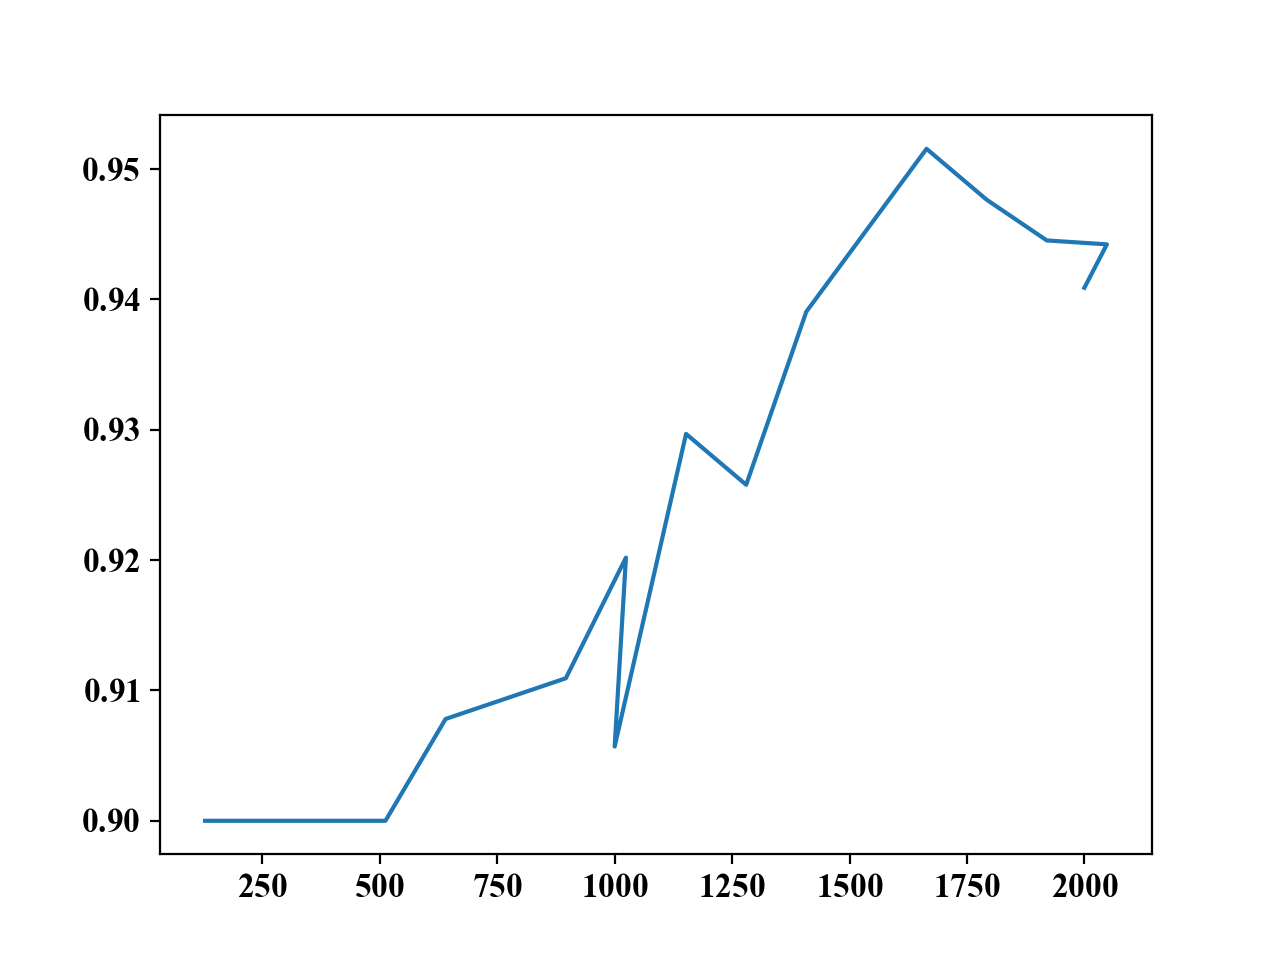

In [51]:
plt.rcParams.update({'font.size': 12})
plt.figure()
plt.plot(batch_log.batch_metric['total_steps'],batch_log.batch_metric['acc'])

## Save Checkpoints

In [31]:
# include the epoch in the file name. (uses `str.format`)
checkpoint_path = "training_2/cp-epoch-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # Save weights, every 5-epochs.
    period=1)


In [59]:
batch_log=NBatchLogger(display=5)
history=firstmodel.fit(x=X_train[:1000, :, :, np.newaxis],
               y=to_categorical(y_train[:1000],num_classes=10),
               validation_data=(X_valid[:100,:,:,np.newaxis],
                                to_categorical(y_valid[:100],num_classes=10)),
               epochs=2, batch_size=128)#, callbacks=[batch_log,cp_callback])

Train on 1000 samples, validate on 100 samples
Epoch 1/2
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0265 - acc: 0.9914 - val_loss: 0.0325 - val_acc: 0.9920
Epoch 2/2
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0273 - acc: 0.9909 - val_loss: 0.0454 - val_acc: 0.9900


In [60]:
history.history


{'val_loss': [0.032498110085725784, 0.04538222402334213],
 'val_acc': [0.9919999837875366, 0.9900000095367432],
 'loss': [0.026533982425928117, 0.02731094853579998],
 'acc': [0.9913999691009522, 0.9908999710083007]}

In [44]:
result = firstmodel.evaluate(x=X_valid[:,:,:,np.newaxis],
                        y=to_categorical(y_valid,num_classes=10))

18000/18000 [==============================] - 43s 2ms/step


In [45]:
print("Loss : {0} ;\nAccuracy : {1} %.".format(result[0],round(result[1]*100,2)))

Loss : 0.08619932247532738 ;
Accuracy : 96.91 %.


## Load Save Model

In [33]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2/cp-epoch-0003.ckpt'

In [34]:
firstmodel.load_weights(latest)